In [15]:
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook
from matplotlib import pyplot as plt

import glob
import os 
import pandas as pd
import numpy as np
import cv2

import shutil
from collections import OrderedDict
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

# SROIE : Data Handling 

## Data cleaning

### Ground truth = Image

Some images are present in the training set but we dont have their groundtruth. 
Or the opposite, so we have to clean the data set.

In [128]:
rm -rf /home/jupyter/Clova/DB_Clova_text/.ipynb_checkpoints/ 

In [129]:
for root, _, files in os.walk("/home/jupyter/Clova/DB_Clova_text/"):
    print(root, len(files))

/home/jupyter/Clova/DB_Clova_text/ 360


In [81]:
#Copy the file names in lists

for root, _, files in os.walk("datasets/SROIE/test_gts0"):
    L_test_gts = files
for root, _, files in os.walk("datasets/SROIE/train_gts0"):
    L_train_gts = files
for root, _, files in os.walk("datasets/SROIE/test_images"):
    L_test_images = files
for root, _, files in os.walk("datasets/SROIE/train_images"):
    L_train_images = files

In [157]:
# We extract .jpg and .txt from the filenames in order to compare the gts name files and the images name files
L_test_gts_without_txt = [i[:-4] for i in L_test_gts]
L_train_gts_without_txt = [i[:-4] for i in L_train_gts]
L_test_images_without_txt = [i[:-4] for i in L_test_images]
L_train_images_without_txt = [i[:-4] for i in L_train_images]

In [158]:
# Python program to illustrate the intersection 
# of two lists 
def intersection(lst1, lst2): 
  
    # Use of hybrid method 
    temp = set(lst2) 
    lst3 = [value for value in lst1 if value in temp] 
    return lst3 

def difference(lst1, lst2): 
  
    # Use of hybrid method 
    temp = set(lst2) 
    lst3 = [value for value in lst1 if value not in temp] 
    return lst3 
  
# Driver Code 
print(difference(L_train_gts_without_txt, L_train_images_without_txt))
print(len(intersection(L_train_gts_without_txt, L_train_images_without_txt)))

[]
626


In [114]:
#Delete all the files that are in one folder but not in the other

for file in difference(L_train_gts_without_txt, L_train_images_without_txt):
    try:
        os.remove("datasets/SROIE/train_images/" + file + ".jpg")
    except:
        os.remove("datasets/SROIE/train_gts/" + file + ".txt")

### Remove duplicates

There are also many files in double even triple so let's clean that as well.

In [130]:
for file in L_train_images:
    if file[-5] == ")":
        os.remove("datasets/SROIE/train_images/" + file)

In [133]:
for file in L_train_gts:
    if file[-5] == ")":
        os.remove("datasets/SROIE/train_gts/" + file)

## Creation of the list of files to run the trainning and test on the model

Now we have to write down the file names in two files :
- *test_list.txt* :  Where there will be all the file names of the test set
- *train_list.txt* :  Where there will be all the file names of the training set

In [142]:
f = open("datasets/SROIE/test_list.txt", "w")
for file in L_test_images:
    f.write(file+"\n")
f.close()

f = open("datasets/SROIE/train_list.txt", "w")
for file in L_train_images:
    f.write(file+"\n")
f.close()

 ### Rename the ground truth namefiles : 

##### ATTENTION DANGER : dont run it twice or you'll have again work to do (I actually did it that's why I encourage you not to fall in the same time consuming hole)

Before : X552983732.txt --> After : X552983732.jpg.txt

In [159]:
for file in L_test_gts:
    os.rename(r'datasets/SROIE/test_gts/'+file,r'datasets/SROIE/test_gts/'+file[:-4]+'.jpg.txt')

In [161]:
for file in L_train_gts:
    os.rename(r'datasets/SROIE/train_gts/'+file,r'datasets/SROIE/train_gts/'+file[:-4]+'.jpg.txt')

# Let's create a Backup of the dataset, just in case 

In [163]:
cp -R datasets/SROIE datasets/SROIE_backup

### Delete the words from the ground truth files

For the detection task, the data of the ground truth should be bounding boxes. 
I.e. each line should look like this :

x1, y1, x2, y2, x3, y3, x4, y4

But we have a different kind of data here. In fact the ground truth is also composed of the word that is encircled by the bounding box. 
That's super cool for the recognition part and I hope we will get there. 
But for now lets first delete all the words and keep only the bounding box.

In [91]:
for file in L_train_gts:
    # Load the dataframe 
    df = pd.read_csv("datasets/SROIE/train_gts0/"+file, sep="\n", header=None, encoding= 'unicode_escape')
    
    L = []
    bb = []
    #Extract Ground truth data and put it in a list
    for i in range(df.shape[0]):
        L.append(df.iloc[i][0].split(",")[:8])

    #Only keep the bounding boxes in a new list called bb
    for k in range(df.shape[0]):
        bb.append(','.join(L[k]))
    #write the bb in the doc

    f = open("datasets/SROIE/train_gts/"+file, "w")
    for k in range(df.shape[0]):
        sentence = bb[k]
        f.write(sentence+"\n")
    f.close()

# Training the detector

We see that even after 400 epochs, the training isn't fruitful, so we decide to stop and test the different models

In [ ]:
!python train.py experiments/seg_detector/sroie_resnet18_deform_thre.yaml --resume models/pre-trained-model-synthtext-resnet18 --num_gpus 1

[INFO] [2021-01-15 22:22:11,722] Resuming from models/pre-trained-model-synthtext-resnet18
[INFO] [2021-01-15 22:22:11,765] Resumed from models/pre-trained-model-synthtext-resnet18
[INFO] [2021-01-15 22:22:11,766] Training epoch 0
--------------------
epoch :  [0]
--------------------
--------------------
loss :  [8.347576141357422]
--------------------
--------------------
learning rate :  [0.01]
--------------------
--------------------
BCE loss list :  []
--------------------
--------------------
Thresh loss list :  []
--------------------
--------------------
L1 loss list :  []
--------------------
[INFO] [2021-01-15 22:22:18,367] step:      0, epoch:   0, loss: 8.347576, lr: 0.010000
[INFO] [2021-01-15 22:22:18,370] bce_loss: 1.279141
[INFO] [2021-01-15 22:22:18,371] thresh_loss: 0.697499
[INFO] [2021-01-15 22:22:18,372] l1_loss: 0.125437
Corrupt JPEG data: bad Huffman code0, ETA:  0: 0:35
[INFO] [2021-01-15 22:28:02,520] Training epoch 1 2
Corrupt JPEG data: bad Huffman code, ETA

In [ ]:
!python train.py experiments/seg_detector/sroie_resnet18_deform_thre.yaml --resume outputs/workspace/DB/SegDetectorModel-seg_detector/deformable_resnet18/L1BalanceCELoss/model/sroie/model_epoch_102_minibatch_16000 --num_gpus 1

[INFO] [2021-01-16 12:38:49,859] Resuming from outputs/workspace/DB/SegDetectorModel-seg_detector/deformable_resnet18/L1BalanceCELoss/model/sroie/model_epoch_102_minibatch_16000
[INFO] [2021-01-16 12:38:49,901] Resumed from outputs/workspace/DB/SegDetectorModel-seg_detector/deformable_resnet18/L1BalanceCELoss/model/sroie/model_epoch_102_minibatch_16000
[INFO] [2021-01-16 12:38:49,902] Training epoch 102
--------------------
epoch :  [102]
--------------------
--------------------
loss :  [1.5855841636657715]
--------------------
--------------------
learning rate :  [0.006462599706235705]
--------------------
--------------------
BCE loss list :  []
--------------------
--------------------
Thresh loss list :  []
--------------------
--------------------
L1 loss list :  []
--------------------
[INFO] [2021-01-16 12:39:07,813] step:      0, epoch: 102, loss: 1.585584, lr: 0.006463
[INFO] [2021-01-16 12:39:07,841] bce_loss: 0.168806
[INFO] [2021-01-16 12:39:07,842] thresh_loss: 0.139941


In [2]:
!python train.py experiments/seg_detector/sroie_resnet50_deform_thre.yaml --resume models/pre-trained-model-synthtext-resnet50 --num_gpus 1

[INFO] [2021-01-16 21:11:02,172] Resuming from models/pre-trained-model-synthtext-resnet50
[INFO] [2021-01-16 21:11:02,335] Resumed from models/pre-trained-model-synthtext-resnet50
[INFO] [2021-01-16 21:11:02,337] Training epoch 0
Corrupt JPEG data: bad Huffman code
--------------------
epoch :  [0]
--------------------
--------------------
loss :  [8.808850288391113]
--------------------
--------------------
learning rate :  [0.007]
--------------------
--------------------
BCE loss list :  []
--------------------
--------------------
Thresh loss list :  []
--------------------
--------------------
L1 loss list :  []
--------------------
[INFO] [2021-01-16 21:11:25,694] step:      0, epoch:   0, loss: 8.808850, lr: 0.007000
[INFO] [2021-01-16 21:11:25,697] bce_loss: 1.401646
[INFO] [2021-01-16 21:11:25,698] thresh_loss: 0.636726
[INFO] [2021-01-16 21:11:25,698] l1_loss: 0.116389
[INFO] [2021-01-16 21:13:31,908] Training epoch 1
Corrupt JPEG data: bad Huffman code ETA:  0: 1: 7
[INFO] 

Th evaluation process isn't adapted to SROIE, that's why we have very bad results, and we wonder if it's not the same case for the training.

In [7]:
!python eval.py experiments/seg_detector/sroie_resnet50_deform_thre.yaml --resume outputs/workspace/DB/SegDetectorModel-seg_detector/deformable_resnet50/L1BalanceCELoss/model/model_epoch_51_minibatch_4000 --box_thresh 0.1

./datasets/SROIE
[INFO] [2021-01-16 23:26:46,172] Resuming from outputs/workspace/DB/SegDetectorModel-seg_detector/deformable_resnet50/L1BalanceCELoss/model/model_epoch_51_minibatch_4000
[INFO] [2021-01-16 23:26:46,256] Resumed from outputs/workspace/DB/SegDetectorModel-seg_detector/deformable_resnet50/L1BalanceCELoss/model/model_epoch_51_minibatch_4000
100%|█████████████████████████████████████████| 360/360 [02:12<00:00,  2.72it/s]
[INFO] [2021-01-16 23:28:58,521] precision : 0.060210 (360)
[INFO] [2021-01-16 23:28:58,521] recall : 0.058431 (360)
[INFO] [2021-01-16 23:28:58,521] fmeasure : 0.059307 (1)


In [119]:
!python eval.py experiments/seg_detector/sroie_resnet50_deform_thre.yaml --resume models/td500_resnet50 --box_thresh 0.1

./datasets/SROIE
[INFO] [2021-01-15 22:02:18,067] Resuming from models/td500_resnet50
[INFO] [2021-01-15 22:02:18,157] Resumed from models/td500_resnet50
100%|█████████████████████████████████████████| 360/360 [01:56<00:00,  3.09it/s]
[INFO] [2021-01-15 22:04:14,881] precision : 0.090903 (360)
[INFO] [2021-01-15 22:04:14,882] recall : 0.075872 (360)
[INFO] [2021-01-15 22:04:14,882] fmeasure : 0.082710 (1)


In [113]:
!python eval.py experiments/seg_detector/sroie_resnet18_deform_thre.yaml --resume models/td500_resnet18 --box_thresh 0.1

./datasets/SROIE
[INFO] [2021-01-15 21:39:31,978] Resuming from models/td500_resnet18
[INFO] [2021-01-15 21:39:32,906] Resumed from models/td500_resnet18
100%|█████████████████████████████████████████| 360/360 [01:51<00:00,  3.24it/s]
[INFO] [2021-01-15 21:41:24,587] precision : 0.090776 (360)
[INFO] [2021-01-15 21:41:24,588] recall : 0.077269 (360)
[INFO] [2021-01-15 21:41:24,588] fmeasure : 0.083480 (1)


In [114]:
!python eval.py experiments/seg_detector/sroie_resnet18_deform_thre.yaml --resume models/ic15_resnet18 --box_thresh 0.1

./datasets/SROIE
[INFO] [2021-01-15 21:41:30,849] Resuming from models/ic15_resnet18
[INFO] [2021-01-15 21:41:31,814] Resumed from models/ic15_resnet18
100%|█████████████████████████████████████████| 360/360 [03:46<00:00,  1.59it/s]
[INFO] [2021-01-15 21:45:18,416] precision : 0.065517 (360)
[INFO] [2021-01-15 21:45:18,417] recall : 0.128403 (360)
[INFO] [2021-01-15 21:45:18,417] fmeasure : 0.086763 (1)


In [115]:
!python eval.py experiments/seg_detector/sroie_resnet50_deform_thre.yaml --resume models/ic15_resnet50 --box_thresh 0.1

./datasets/SROIE
[INFO] [2021-01-15 21:45:24,832] Resuming from models/ic15_resnet50
[INFO] [2021-01-15 21:45:26,543] Resumed from models/ic15_resnet50
100%|█████████████████████████████████████████| 360/360 [03:58<00:00,  1.51it/s]
[INFO] [2021-01-15 21:49:25,360] precision : 0.075884 (360)
[INFO] [2021-01-15 21:49:25,360] recall : 0.154953 (360)
[INFO] [2021-01-15 21:49:25,361] fmeasure : 0.101877 (1)


In [116]:
!python eval.py experiments/seg_detector/sroie_resnet18_deform_thre.yaml --resume models/totaltext_resnet18 --box_thresh 0.1

./datasets/SROIE
[INFO] [2021-01-15 21:49:31,646] Resuming from models/totaltext_resnet18
[INFO] [2021-01-15 21:49:31,691] Resumed from models/totaltext_resnet18
100%|█████████████████████████████████████████| 360/360 [03:37<00:00,  1.66it/s]
[INFO] [2021-01-15 21:53:09,463] precision : 0.045364 (360)
[INFO] [2021-01-15 21:53:09,464] recall : 0.084929 (360)
[INFO] [2021-01-15 21:53:09,464] fmeasure : 0.059139 (1)


In [117]:
!python eval.py experiments/seg_detector/sroie_resnet50_deform_thre.yaml --resume models/totaltext_resnet50 --box_thresh 0.1

./datasets/SROIE
[INFO] [2021-01-15 21:53:15,783] Resuming from models/totaltext_resnet50
[INFO] [2021-01-15 21:53:15,877] Resumed from models/totaltext_resnet50
100%|█████████████████████████████████████████| 360/360 [03:48<00:00,  1.58it/s]
[INFO] [2021-01-15 21:57:04,015] precision : 0.034093 (360)
[INFO] [2021-01-15 21:57:04,016] recall : 0.066039 (360)
[INFO] [2021-01-15 21:57:04,016] fmeasure : 0.044970 (1)


In [120]:
!python eval.py experiments/seg_detector/sroie_resnet50_deform_thre.yaml --resume models/pre-trained-model-synthtext-resnet50 --box_thresh 0.1

./datasets/SROIE
[INFO] [2021-01-15 22:05:30,961] Resuming from models/pre-trained-model-synthtext-resnet50
[INFO] [2021-01-15 22:05:32,590] Resumed from models/pre-trained-model-synthtext-resnet50
100%|█████████████████████████████████████████| 360/360 [02:54<00:00,  2.06it/s]
[INFO] [2021-01-15 22:08:27,511] precision : 0.081733 (360)
[INFO] [2021-01-15 22:08:27,511] recall : 0.116292 (360)
[INFO] [2021-01-15 22:08:27,511] fmeasure : 0.095997 (1)


# Let's now infer all SROIE test images 

## We output the results in a folder called BB_infered_with_DB 

In [32]:
!python eval.py experiments/seg_detector/sroie_resnet50_deform_thre.yaml --resume models/ic15_resnet50 --result_dir /home/jupyter/Clova/BB_infered_with_DB   --box_thresh 0.1 --visualize

./datasets/SROIE
[INFO] [2021-01-17 14:53:36,078] Resuming from models/ic15_resnet50
[INFO] [2021-01-17 14:53:38,062] Resumed from models/ic15_resnet50
100%|█████████████████████████████████████████| 360/360 [04:52<00:00,  1.23it/s]
[INFO] [2021-01-17 14:58:30,796] precision : 0.075782 (360)
[INFO] [2021-01-17 14:58:30,796] recall : 0.155005 (360)
[INFO] [2021-01-17 14:58:30,797] fmeasure : 0.101796 (1)


# Retrieving text from the Bounding boxes with Resnet / BiLSTM / Attn

The model for retrieving the text from the bounding boxes that we are ging to use is composed of 4 modules : 

- Transformation : TPS
- FeatureExtraction : ResNet 
- SequenceModeling : BiLSTM 
- Prediction : Attn

1. First go through files in BB_infered_with_DB : those are the text files with the bounding boxes
2. For each file, write down in a file the results obtained with ClovAI
- For the second point, I have to write a new python file where I use the model to predict text for each text box
- Then write the infered text in a txt file 

### Go through each file, and crop images for each bounding box and save it

##### Go through each file in BB_infered_with_DB and crop images for each bounding box and put it in a filename_folder
- Boucle sur les files de BB_inferes_with_DB
    - Pour chaque file, Crop images et les enregistrer dans des demo_image/filename_folder

In [60]:
files = glob.glob('/home/jupyter/Clova/BB_infered_with_DB/*')

In [61]:
filenames = [file[39:][:-4] for file in files]

In [95]:
image_folder = "/home/jupyter/DB/DB/datasets/SROIE/test_images/"

for file in filenames:
    BB = pd.read_fwf('/home/jupyter/Clova/BB_infered_with_DB/'+file+'.txt', header = None) # List of all text bounding boxes of a file infered by DB

    #Extract the k eme bounding box
    path = '/home/jupyter/Clova/demo_image/'+file
    os.mkdir(path)
    for k in range(BB.shape[0]):
        #Read the image without bounding boxes
        img = cv2.imread(image_folder+file[4:]+'.jpg')
        l_char = BB[0][k].split(",")
        l = [int(i) for i in l_char[:8]] # [x1, y1, x2, y2, x3, y3, x4, y4]

        x1, y1, x2, y2, x3, y3, x4, y4 = l[0],l[1],l[2],l[3],l[4],l[5],l[6],l[7]

        crop_img = img[y1:y3, x1:x2]
        
        filename = '/'+file+'_demo_'+str(k)+'.jpg'
        
        # Using cv2.imwrite() method 
        # Saving the image 
        try:
            cv2.imwrite(path + filename, crop_img)
        except:
            continue

datasets/SROIE/test_images/X00016469670.jpg


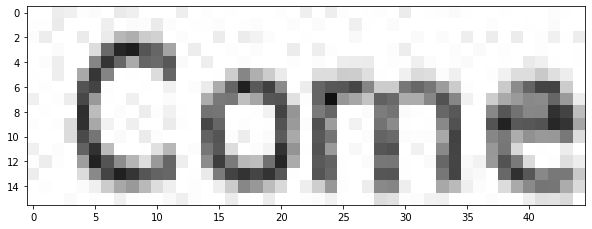

In [15]:
image_folder = "datasets/SROIE/test_images/"

#Read the image without bounding boxes

print(image_folder+file[4:-4]+'.jpg')
img = cv2.imread(image_folder+file[4:-4]+'.jpg')


crop_img = img[y1:y3, x1:x2]

#Show the image with matplotlib
plt.imshow(crop_img)
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

Let's verify that we have the 360 folders for the 360 images 

In [103]:
files = folders = 0

for _, dirnames, filenames in os.walk("/home/jupyter/Clova/demo_image/"):
  # ^ this idiom means "we won't be using this value"
    files += len(filenames)
    folders += len(dirnames)

print("{:,} files, {:,} folders".format(files, folders))

39,450 files, 360 folders


### Text recognition over the bouding box images

Now let's run Clova model on each image to get the text instances.

We want to have the output results in the following format "x1, y1, x2, y2, x3, y3, x4, y4, detection_probability, word, recognition_probability" for each image

##### Test over one folder

In [115]:
!CUDA_VISIBLE_DEVICES=0 python3 /home/jupyter/Clova/BB2text.py \
--sensitive \
--Transformation TPS --FeatureExtraction ResNet --SequenceModeling BiLSTM --Prediction Attn \
--image_folder /home/jupyter/Clova/demo_image/res_X00016469670/ \
--saved_model /home/jupyter/Clova/TPS-ResNet-BiLSTM-Attn-case-sensitive.pth 

model input parameters 32 100 20 1 512 256 96 25 TPS ResNet BiLSTM Attn
loading pretrained model from /home/jupyter/Clova/TPS-ResNet-BiLSTM-Attn-case-sensitive.pth


#### Lets go through all folders

In [119]:
files = glob.glob('/home/jupyter/Clova/BB_infered_with_DB/*')

In [120]:
filenames = [file[39:][:-4] for file in files]

In [121]:
filenames[0]

'res_X51005675099'

#### We launch the file BB2text.py that I wrote in order to write down the predictions the way we want 

("x1, y1, x2, y2, x3, y3, x4, y4, detection_probability, word, recognition_probability")

In [ ]:
for file in filenames:
    !CUDA_VISIBLE_DEVICES=0 python3 /home/jupyter/Clova/BB2text.py --sensitive --Transformation TPS --FeatureExtraction ResNet --SequenceModeling BiLSTM --Prediction Attn --image_folder /home/jupyter/Clova/demo_image/{file}/  --saved_model /home/jupyter/Clova/TPS-ResNet-BiLSTM-Attn-case-sensitive.pth

# From words to sentences

### Now lets create a way to move from words to sentences putting together the closest bounding boxes

The idea is that for for those following lines : 

247,28,314,28,314,61,247,61,0.7435584,yee                      ,0.9999
100,28,157,28,157,57,100,57,0.86152625,tan                      ,1.0000
165,23,245,26,244,63,163,60,0.83061576,chay                     ,0.9998

We output :
100,28,314,28,314,63,100,63,yee tan chay

We have to find a way to infer the "closiness of two words".

Generally, the spacement between two words, according to typography rules, are never bigger than the vertical size of a letter upside down.

##### This means that we have to the following things : 

- measure the maximal vertical size of the word : max(y3-y1)
- Find the closest word of word 1
- if right distance is inferior to the vertical height multiplied by 1.5 : add it to the right of the word
- if left distance is inferior to the vertical height multiplied by 1.5 : add it to the left of the word

In [36]:
def words_to_sentences(filename, input_path = '/home/jupyter/Clova/DB_Clova_text/', output_path = "/home/jupyter/Clova/DB_Clova_sentences/", word_size_difference = 0.4, distance_between_words = 2 , vertical_shift_between_words = 0.5, threshold = 0):
    '''
    INPUT
    Here I wrote a function that takes a file name as input
        To be more detailed : In the file there should be the bounding boxes of each word detected and the word associated to the bounding box.
        
    ARGUMENTS:
        input_path : By default, we've put the input files in a folder called "/DB_Clova_text" but if you decided otherwise, you can just change the input_file
        output_path : By default, we decided to put all th sentences in a foolder called "/DB_Clova_sentences" but if you decided otherwise, you can just change the output_file
        
        
        word_size_difference : The maximum relative difference of size between words to say they belong to the same sentence. (We chose 0.4 empirically)
        distance_between_words : The maximum distance which will be relative to the vertical size of the words to say that they belong to the same sentence. (We chose 2 empirically)
        vertical_shift_between_words : The maximum admitted shift between words to say that the words belong to the same sentence. It will be proportional to the vertical size of the words. (We chose 0.5 empirically)
        threshold : It's animportant threshold fixed in order to put aside the wrongly detected boxes or wrongly recognized text. We put the condition on the product (detection_probability x recognition_probability) in order to be consistant and deal with the intersection of both phenomenons. (By default we fix no threshold)
    OUTPUT
        And that output a text file with all the sentences detected and infered by the model in the file
    '''
    
    BB_reco_text = pd.read_fwf(input_path + filename, header = None) # List of all text bounding boxes of a file infered by DB

    BB_reco_text[0][BB_reco_text.shape[0]-1]

    L = []
    newL = [[]] # liste des indices des mots ensemble : [[0,1,2], [3,4], [5]...]

    for k in range(BB_reco_text.shape[0]):
        n = BB_reco_text.shape[0] - k -1
        L.append(BB_reco_text[0][n])

    for k in range(len(L)):

        l_char = L[k].split(",")
        l = [i for i in l_char[:10]] # [x1, y1, x2, y2, x3, y3, x4, y4]
        x1, y1, x2, y2, x3, y3, x4, y4, detection_probability, word, recognition_probability = int(l[0]),int(l[1]),int(l[2]),int(l[3]),int(l[4]),int(l[5]),int(l[6]),int(l[7]), float(l[8]), l[9], float(BB_reco_text[1][k][1:])
        vertical_size_of_word = y3-y1
        probability = detection_probability * recognition_probability 
        
        for j in range(1,20):
            if k+j<len(L):
                l_char = L[k+j].split(",")
                l = [i for i in l_char[:10]] # [x1, y1, x2, y2, x3, y3, x4, y4]
                comparable_x1, comparable_y1, comparable_x2, comparable_y2, comparable_x3, comparable_y3, comparable_x4, comparable_y4, comparable_detection_probability, comparable_word, comparable_recognition_probability = int(l[0]),int(l[1]),int(l[2]),int(l[3]),int(l[4]),int(l[5]),int(l[6]),int(l[7]), float(l[8]), l[9], float(BB_reco_text[1][k+j][1:])
                comparable_vertical_size_of_word = comparable_y3-comparable_y1
                comparable_probability = comparable_detection_probability * comparable_recognition_probability
                
                # Check if the comparable word comes AFTER word check the "distance" between bounding boxes
                if (min(comparable_probability,probability) >= threshold and  abs(vertical_size_of_word - comparable_vertical_size_of_word) < word_size_difference * vertical_size_of_word) and (comparable_x1 - x2 <  distance_between_words * vertical_size_of_word) and (comparable_x1 -x2 >0) and (abs(y1 - comparable_y1) <  vertical_shift_between_words * vertical_size_of_word):
                    #print("1. Detecte le mot d'apres : ",L[k],L[k+j], "\n et les indices sont : k = ", k, "; k + j = ", k + j)

                    #If k is in the list, we should add k+j to the list to th right of k 
                    if k in newL[-1]:
                        newL[-1].insert(newL[-1].index(k)+1, k+j) # newL[-1].index(k)+1 (+1) because is to the right of k

                    #If k+j is in the list, we should add k to the list to the left of k 
                    elif k+j in newL[-1]:
                        newL[-1].insert(newL[-1].index(k+j), k)
                    #If neither k nor k+j are in the list
                    else : 
                        newL.append([k,k+j])
                # Check if the comparable word comes BEFORE  word
                elif (min(comparable_probability,probability) >= threshold and abs(vertical_size_of_word - comparable_vertical_size_of_word) < word_size_difference * vertical_size_of_word) and (comparable_x2 - x1 <  distance_between_words * vertical_size_of_word) and (comparable_x2 -x1 >0) and (abs(y1 - comparable_y1) <  vertical_shift_between_words * vertical_size_of_word):
                    #print("1. Detecte le mot d'avant : ",L[k+j],L[k], "\n et les indices sont : k = ", k, "; k + j = ", k+j)

                    #If k is in the list, we should add k+j to the list to the left of k 
                    if k in newL[-1]:
                        newL[-1].insert(newL[-1].index(k), k+j) # newL[-1].index(k)+1 (+1) because is to the right of k

                    #If k+j is in the list, we should add k to the list to the right of k 
                    elif k+j in newL[-1]:
                        newL[-1].insert(newL[-1].index(k+j) + 1, k)

                    #If neither k nor k+j are in the list
                    else : 
                        newL.append([k+j,k])
            else :
                break

        for j in range(1,20):
            if k-j>=0:
                l_char = L[k-j].split(",")
                l = [i for i in l_char[:10]] # [x1, y1, x2, y2, x3, y3, x4, y4]
                comparable_x1, comparable_y1, comparable_x2, comparable_y2, comparable_x3, comparable_y3, comparable_x4, comparable_y4, comparable_detection_probability, comparable_word, comparable_recognition_probability = int(l[0]),int(l[1]),int(l[2]),int(l[3]),int(l[4]),int(l[5]),int(l[6]),int(l[7]), float(l[8]), l[9], float(BB_reco_text[1][k-j][1:])
                comparable_vertical_size_of_word = comparable_y3-comparable_y1
                
                comparable_probability = comparable_detection_probability * comparable_recognition_probability
                # Check if the comparable word comes AFTER word check the "distance" between bounding boxes
                if (min(comparable_probability,probability) >= threshold and abs(vertical_size_of_word - comparable_vertical_size_of_word) < word_size_difference * vertical_size_of_word) and (comparable_x1 - x2 < distance_between_words * vertical_size_of_word) and (comparable_x1 - x2 >0) and (abs(y1 - comparable_y1) <  vertical_shift_between_words * vertical_size_of_word):
                    #print("2. Detecte le mot d'apres : ",L[k],L[k-j], "\n et les indices sont : k = ", k, "; k - j = ", k-j)

                    #If k is in the list, we should add k-j to the list to th right of k 
                    if k in newL[-1]:
                        newL[-1].insert(newL[-1].index(k)+1, k-j) # newL[-1].index(k)+1 (+1) because is to the right of k

                    #If k+j is in the list, we should add k to the list to the left of k 
                    elif k-j in newL[-1]:
                        newL[-1].insert(newL[-1].index(k-j), k)

                    #If neither k nor k-j are in the list
                    else : 
                        newL.append([k,k-j])
                elif (min(comparable_probability,probability) >= threshold and abs(vertical_size_of_word - comparable_vertical_size_of_word) < word_size_difference * vertical_size_of_word) and (comparable_x2 - x1 < distance_between_words * vertical_size_of_word) and (comparable_x2 -x1 >0) and (abs(y1 - comparable_y1) <  vertical_shift_between_words * vertical_size_of_word):
                    #print("2. Detecte le mot d'avant : ",L[k-j],L[k], "\n et les indices sont : k = ", k, "; k - j = ", k-j)

                    #If k is in the list, we should add k+j to the list to the left of k 
                    if k in newL[-1]:
                        newL[-1].insert(newL[-1].index(k), k-j) # newL[-1].index(k)+1 (+1) because is to the right of k

                    #If k+j is in the list, we should add k to the list to the right of k 
                    elif k-j in newL[-1]:
                        newL[-1].insert(newL[-1].index(k-j) + 1, k)

                    #If neither k nor k-j are in the list
                    else : 
                        newL.append([k-j,k])
            else :
                break

    newL = newL[1:]  # We remove the empty list [] from the list
    
    
    #Remove duplicates from lists maintaining the right order

    for i in range(len(newL)):
        newL[i] = list(OrderedDict.fromkeys(newL[i]))

    #List containing the indexes of the words without neighbors
    list_singular_words_index = []
    for i in range(len(newL)):
        if i == len(newL)-1:
            M = len(L)-max(newL[i])
        else:
            M = min(newL[i+1])-max(newL[i])

        if M>0:
            for k in range(1,M):
                list_singular_words_index.append([max(newL[i])+k])

    #Let's add the lonely words (those who don't have any neighbors)
    
    processed_list_of_indexes = [i for i in newL] 
    list_of_max_indexes = [max(i) for i in (newL+list_singular_words_index)]
    list_of_max_indexes.sort()
    for i in range(len(list_singular_words_index)):
        processed_list_of_indexes.insert(list_of_max_indexes.index(list_singular_words_index[i][0]), list_singular_words_index[i]) # Whole list of index with singular as well as neighbored words
    
    #We write the results in a file in the folder of output
        
    f = open(output_path + filename, "w")
    for k in range(len(processed_list_of_indexes)):
        sentence = ""
        for j in range(len(processed_list_of_indexes[k])):
            l_char = L[processed_list_of_indexes[k][j]].split(",")
            l = [i for i in l_char[:10]] # [x1, y1, x2, y2, x3, y3, x4, y4]
            
            detection_probability, word, recognition_probability = float(l[8]), l[9], float(BB_reco_text[1][processed_list_of_indexes[k][j]][1:])
            probability = detection_probability * recognition_probability 
            if (probability>=threshold):
                sentence += " " + word
        f.write(sentence+"\n")
    f.close()
    
    return

In [39]:
words_to_sentences("X00016469670.txt")

In [20]:
files = glob.glob('/home/jupyter/Clova/DB_Clova_text/*')
files_to_sentence = [file[34:] for file in files]

for file in files_to_sentence:
    words_to_sentences(file)

# Qualitative results

tan chay yee
COPY
OJC MARKETING SDN BHD
ROC
NO: 538358-H
NO 2 4 8
4
JALAN BAYU
BANDAR SERI ALAM
81750 MASAI JOHOR
Tel:07 .388 2218 Fax:07-388 8218
Email: ingo bojogroup. .com
TAX INVOICE
the
Invoice TRE PEGIV-1030765
15/01/2019 11:05:16 AM
NG
MIN
CHUAN
Cashier
Sales
Persor FATIN
Bill To
THE PEAK QUARRY WORKS
Addr ress
Oty Price Amount
Description
and
193. .00 193.00
SHOES KWD
KINGS SAFETY SHOES
Oty:11 Total Exclude GST:
193.00
Total Q6%; GST
0
Total Inclusive GST:
Round Amt:
0.00
TOTAL:
193.00
and
VISA
card
193.00
x00xxxxx000x4 .318
Approval Code:
(193-CO
Goods Sold Not Returnable 2 Are
Refundable
++Thank Please Come Again. You.


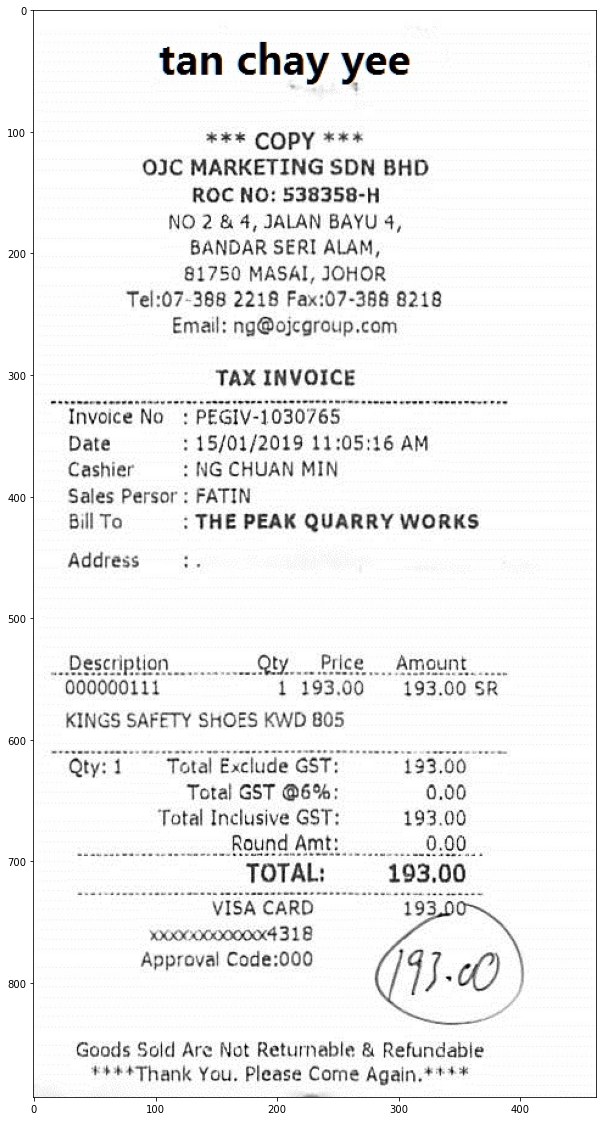

In [41]:
img = cv2.imread("/home/jupyter/DB/DB/datasets/SROIE/test_images/X00016469670.jpg")

text_result = pd.read_fwf('/home/jupyter/Clova/DB_Clova_sentences/X00016469670.txt', header = None) 
for k in range(text_result.shape[0]):
    print(text_result[0][k])
    
#Show the image with matplotlib
plt.imshow(img)
plt.rcParams["figure.figsize"] = (20,20)
plt.show()

PANA JAYA ENTERPA ISE
FLOOR JALAN DINAR I
NOAIO-G GROUND FLOOR
U3/D TAMAN SUBANG PEADANA
SEK YO1SO U3 SHAH ALAM SELANGOR
TEL:03-7847 2376 ALAM FAX 03 .7847
464)
(GST Reg Na 0020694381
Tax Invo jce
Qty(s):
INV
No 53940S
10 21-03-2018 337:49
Date
Cashi jel CASHIERZ
Total TAX
Qty Uppice Total
Descr tiption Qty
28 9928 IN BASIN
35 LOO SR
3S OO
TG WFD32 BOWL CTN PP
70X00 70A0 SA
GST)
qu OE
Total (Excluding GST)
qu
GST payabl (E%)
It
105 OO
GST
Total Unclys
Unclys ive of GST
105 OOK
TOTAL
105
00
CASH
GST Summary
Summary
Amount.AM) Tax(AM)
gy
SA
gg
OE
E%
IOS
stant
Thank You
lease Come Agai in
a
Goods Sold Ara
Not Ref undab


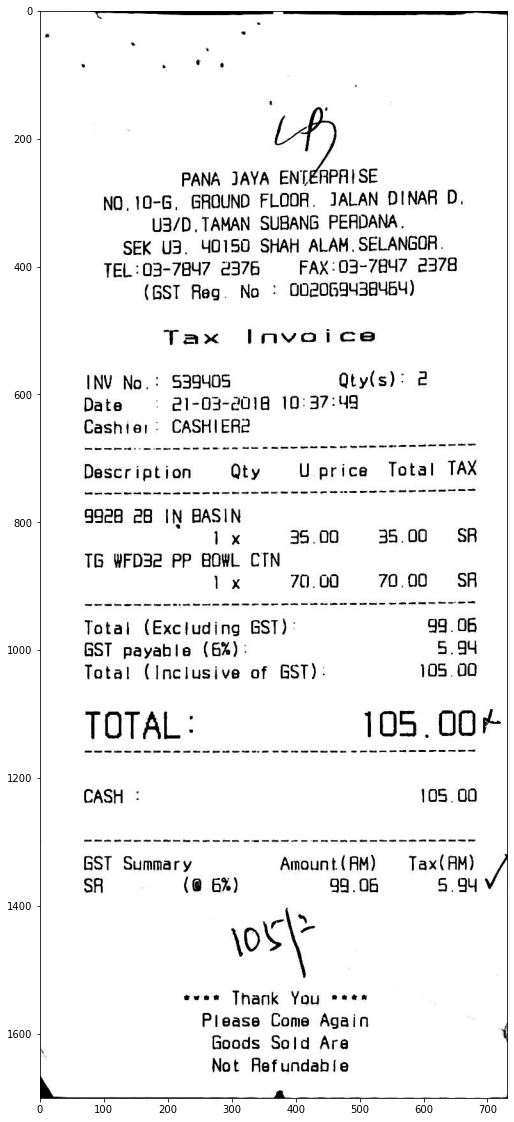

In [42]:
img = cv2.imread("/home/jupyter/DB/DB/datasets/SROIE/test_images/X51005746206.jpg")

text_result = pd.read_fwf('/home/jupyter/Clova/DB_Clova_sentences/X51005746206.txt', header = None) 
for k in range(text_result.shape[0]):
    print(text_result[0][k])
    
#Show the image with matplotlib
plt.imshow(img)
plt.rcParams["figure.figsize"] = (20,20)
plt.show()

## Quantitative analysis 

### Quantitative result on the detection part

We have to reprocess the file names in order to be recognized when compared

In [109]:
for root, _, files in os.walk("/home/jupyter/DB/DB/evaluation_ilyass/evaluation_task_1/test_files/infered_files/"):
    L_infered = files

In [51]:
for file in L_infered:
    os.rename(r'/home/jupyter/DB/DB/evaluation_ilyass/evaluation_task_1/test_files/infered_files/'+file,r'/home/jupyter/DB/DB/evaluation_ilyass/evaluation_task_1/test_files/infered_files/'+file[:-8])

In [103]:
for root, _, files in os.walk("/home/jupyter/DB/DB/evaluation_ilyass/evaluation_task_1/test_files/gt_files"):
    L_gt = files

In [61]:
for file in L_gt:
    os.rename(r'/home/jupyter/DB/DB/evaluation_ilyass/evaluation_task_1/test_files/gt_files/'+file,r'/home/jupyter/DB/DB/evaluation_ilyass/evaluation_task_1/test_files/gt_files/'+file[:-8]+'.txt')

We also have to retrieve the probability from all files in order to be proceeded 

In [110]:
L_infered

['X51005719823.txt',
 'X51005757220.txt',
 'X51006387973.txt',
 'X51006414425.txt',
 'X51006334927.txt',
 'X51006389894.txt',
 'X51006619782.txt',
 'X51005587261.txt',
 'X51006556809.txt',
 'X51005663323.txt',
 'X51009008095.txt',
 'X51008099088.txt',
 'X51005663310.txt',
 'X51006328937.txt',
 'X51006557196.txt',
 'X51005724625.txt',
 'X51005719855.txt',
 'X51006349083.txt',
 'X51005806718.txt',
 'X51005745298.txt',
 'X51005442382.txt',
 'X51006619766.txt',
 'X51007231274.txt',
 'X51005433518.txt',
 'X51007846289.txt',
 'X51007339127.txt',
 'X51005719889.txt',
 'X51006619869.txt',
 'X51007339116.txt',
 'X51006619509.txt',
 'X51005444046.txt',
 'X51005806720.txt',
 'X51005288570.txt',
 'X51007846288.txt',
 'X51006619790.txt',
 'X51005605287.txt',
 'X51005447841.txt',
 'X51007433809.txt',
 'X51005361923.txt',
 'X51006556734.txt',
 'X51005724552.txt',
 'X51005675103.txt',
 'X51005763999.txt',
 'X51005764161.txt',
 'X51006438346.txt',
 'X51007846379.txt',
 'X51007231372.txt',
 'X5100639216

In [111]:
for file in L_infered:
    # Load the dataframe 
    df = pd.read_csv("/home/jupyter/DB/DB/evaluation_task_1/test/test_files/infered_files/"+file, sep="\n", header=None, encoding= 'unicode_escape')
    
    L = []
    bb = []
    #Extract data and put it in a list
    for i in range(df.shape[0]):
        L.append(df.iloc[i][0].split(",")[:8])

    #Only keep the bounding boxes in a new list called bb
    for k in range(df.shape[0]):
        bb.append(','.join(L[k]))
    #write the bb in the doc

    f = open("/home/jupyter/DB/DB/evaluation_task_1/test/test_files/infered_files/"+file, "w")
    for k in range(df.shape[0]):
        sentence = bb[k]
        f.write(sentence+"\n")
    f.close()

On va d'abord zipper tous les ground truth files

In [112]:
cd /home/jupyter/DB/DB/evaluation_ilyass/evaluation_task_1/test_files/gt_files/

/home/jupyter/DB/DB/evaluation_task_1/test/test_files/gt_files


In [99]:
ls -a

./                   X51005715007.txt  X51006401845.txt  X51006828200.txt
../                  X51005715455.txt  X51006401853.txt  X51006828201.txt
.ipynb_checkpoints/  X51005719823.txt  X51006401940.txt  X51006856982.txt
X00016469670.txt     X51005719855.txt  X51006401977.txt  X51006857126.txt
X00016469671.txt     X51005719857.txt  X51006414425.txt  X51006857132.txt
X51005200931.txt     X51005719863.txt  X51006414427.txt  X51006857137.txt
X51005230605.txt     X51005719888.txt  X51006414433.txt  X51006857540.txt
X51005230616.txt     X51005719889.txt  X51006414512.txt  X51006912959.txt
X51005230621.txt     X51005719895.txt  X51006414532.txt  X51006912976.txt
X51005230648.txt     X51005719898.txt  X51006414592.txt  X51006912998.txt
X51005230657.txt     X51005719903.txt  X51006414593.txt  X51006913018.txt
X51005230659.txt     X51005719905.txt  X51006414600.txt  X51006913032.txt
X51005268275.txt     X51005724552.txt  X51006414632.txt  X51006913060.txt
X51005268408.txt     X51005724609.txt 

In [100]:
rm -rf .ipynb_checkpoints/ 

In [113]:
!zip -r task1_gt.zip *

  adding: X00016469670.txt (deflated 53%)
  adding: X00016469671.txt (deflated 55%)
  adding: X51005200931.txt (deflated 58%)
  adding: X51005230605.txt (deflated 55%)
  adding: X51005230616.txt (deflated 53%)
  adding: X51005230621.txt (deflated 57%)
  adding: X51005230648.txt (deflated 55%)
  adding: X51005230657.txt (deflated 56%)
  adding: X51005230659.txt (deflated 53%)
  adding: X51005268275.txt (deflated 58%)
  adding: X51005268408.txt (deflated 52%)
  adding: X51005288570.txt (deflated 56%)
  adding: X51005301666.txt (deflated 58%)
  adding: X51005337867.txt (deflated 57%)
  adding: X51005337877.txt (deflated 57%)
  adding: X51005361906.txt (deflated 60%)
  adding: X51005361908.txt (deflated 58%)
  adding: X51005361912.txt (deflated 56%)
  adding: X51005361923.txt (deflated 55%)
  adding: X51005365187.txt (deflated 59%)
  adding: X51005433518.txt (deflated 55%)
  adding: X51005433543.txt (deflated 55%)
  adding: X51005433548.txt (deflated 57%)
  adding: X51005433556.txt (deflat

In [114]:
cd /home/jupyter/DB/DB/evaluation_ilyass/evaluation_task_1/test_files/infered_files/

/home/jupyter/DB/DB/evaluation_task_1/test/test_files/infered_files


In [107]:
ls -a

./                   X51005715007.txt  X51006401845.txt  X51006828200.txt
../                  X51005715455.txt  X51006401853.txt  X51006828201.txt
.ipynb_checkpoints/  X51005719823.txt  X51006401940.txt  X51006856982.txt
X00016469670.txt     X51005719855.txt  X51006401977.txt  X51006857126.txt
X00016469671.txt     X51005719857.txt  X51006414425.txt  X51006857132.txt
X51005200931.txt     X51005719863.txt  X51006414427.txt  X51006857137.txt
X51005230605.txt     X51005719888.txt  X51006414433.txt  X51006857540.txt
X51005230616.txt     X51005719889.txt  X51006414512.txt  X51006912959.txt
X51005230621.txt     X51005719895.txt  X51006414532.txt  X51006912976.txt
X51005230648.txt     X51005719898.txt  X51006414592.txt  X51006912998.txt
X51005230657.txt     X51005719903.txt  X51006414593.txt  X51006913018.txt
X51005230659.txt     X51005719905.txt  X51006414600.txt  X51006913032.txt
X51005268275.txt     X51005724552.txt  X51006414632.txt  X51006913060.txt
X51005268408.txt     X51005724609.txt 

In [108]:
rm -rf .ipynb_checkpoints/ 

In [115]:
!zip -r submit_ilyass.zip *

  adding: X00016469670.txt (deflated 64%)
  adding: X00016469671.txt (deflated 62%)
  adding: X51005200931.txt (deflated 64%)
  adding: X51005230605.txt (deflated 64%)
  adding: X51005230616.txt (deflated 64%)
  adding: X51005230621.txt (deflated 63%)
  adding: X51005230648.txt (deflated 62%)
  adding: X51005230657.txt (deflated 62%)
  adding: X51005230659.txt (deflated 61%)
  adding: X51005268275.txt (deflated 62%)
  adding: X51005268408.txt (deflated 57%)
  adding: X51005288570.txt (deflated 64%)
  adding: X51005301666.txt (deflated 62%)
  adding: X51005337867.txt (deflated 63%)
  adding: X51005337877.txt (deflated 61%)
  adding: X51005361906.txt (deflated 65%)
  adding: X51005361908.txt (deflated 62%)
  adding: X51005361912.txt (deflated 61%)
  adding: X51005361923.txt (deflated 61%)
  adding: X51005365187.txt (deflated 64%)
  adding: X51005433518.txt (deflated 63%)
  adding: X51005433543.txt (deflated 62%)
  adding: X51005433548.txt (deflated 61%)
  adding: X51005433556.txt (deflat

Maintenant on va essayer delancer le test

In [117]:
cd /home/jupyter/DB/DB/evaluation_ilyass/evaluation_task_1

/home/jupyter/DB/DB/evaluation_task_1/test


In [118]:
!python script.py –g=task1_gt.zip –s=submit_ilyass.zip

Calculated!{"precision": 0.6612535107917317, "recall": 0.636811084686175, "hmean": 0.648802173523253}

### Quantitative result on the recognition part

In [43]:
def words_to_sentences_with_BB(filename, input_path = '/home/jupyter/Clova/DB_Clova_text/', output_path = "/home/jupyter/Clova/DB_Clova_sentences/", word_size_difference = 0.4, distance_between_words = 2 , vertical_shift_between_words = 0.5, threshold = 0):
    '''
    INPUT
    Here I wrote a function that takes a file name as input
        To be more detailed : In the file there should be the bounding boxes of each word detected and the word associated to the bounding box.
        
    ARGUMENTS:
        input_path : By default, we've put the input files in a folder called "/DB_Clova_text" but if you decided otherwise, you can just change the input_file
        output_path : By default, we decided to put all th sentences in a foolder called "/DB_Clova_sentences" but if you decided otherwise, you can just change the output_file
        
        
        word_size_difference : The maximum relative difference of size between words to say they belong to the same sentence. (We chose 0.4 empirically)
        distance_between_words : The maximum distance which will be relative to the vertical size of the words to say that they belong to the same sentence. (We chose 2 empirically)
        vertical_shift_between_words : The maximum admitted shift between words to say that the words belong to the same sentence. It will be proportional to the vertical size of the words. (We chose 0.5 empirically)
        threshold : It's animportant threshold fixed in order to put aside the wrongly detected boxes or wrongly recognized text. We put the condition on the product (detection_probability x recognition_probability) in order to be consistant and deal with the intersection of both phenomenons. (By default we fix no threshold)
    OUTPUT
        And that output a text file with all the sentences detected and infered by the model in the file
    '''
    
    BB_reco_text = pd.read_fwf(input_path + filename, header = None) # List of all text bounding boxes of a file infered by DB

    BB_reco_text[0][BB_reco_text.shape[0]-1]

    L = []
    newL = [[]] # liste des indices des mots ensemble : [[0,1,2], [3,4], [5]...]

    for k in range(BB_reco_text.shape[0]):
        n = BB_reco_text.shape[0] - k -1
        L.append(BB_reco_text[0][n])

    for k in range(len(L)):

        l_char = L[k].split(",")
        l = [i for i in l_char[:10]] # [x1, y1, x2, y2, x3, y3, x4, y4]
        x1, y1, x2, y2, x3, y3, x4, y4, detection_probability, word = int(l[0]),int(l[1]),int(l[2]),int(l[3]),int(l[4]),int(l[5]),int(l[6]),int(l[7]), float(l[8]), l[9]
        vertical_size_of_word = y3-y1
        #probability = detection_probability * recognition_probability 
        
        for j in range(1,20):
            if k+j<len(L):
                l_char = L[k+j].split(",")
                l = [i for i in l_char[:10]] # [x1, y1, x2, y2, x3, y3, x4, y4]
                comparable_x1, comparable_y1, comparable_x2, comparable_y2, comparable_x3, comparable_y3, comparable_x4, comparable_y4, comparable_detection_probability, comparable_word = int(l[0]),int(l[1]),int(l[2]),int(l[3]),int(l[4]),int(l[5]),int(l[6]),int(l[7]), float(l[8]), l[9]
                comparable_vertical_size_of_word = comparable_y3-comparable_y1
                #comparable_probability = comparable_detection_probability * comparable_recognition_probability
                
                # Check if the comparable word comes AFTER word check the "distance" between bounding boxes
                if ( abs(vertical_size_of_word - comparable_vertical_size_of_word) < word_size_difference * vertical_size_of_word) and (comparable_x1 - x2 <  distance_between_words * vertical_size_of_word) and (comparable_x1 -x2 >0) and (abs(y1 - comparable_y1) <  vertical_shift_between_words * vertical_size_of_word):
                    #print("1. Detecte le mot d'apres : ",L[k],L[k+j], "\n et les indices sont : k = ", k, "; k + j = ", k + j)

                    #If k is in the list, we should add k+j to the list to th right of k 
                    if k in newL[-1]:
                        newL[-1].insert(newL[-1].index(k)+1, k+j) # newL[-1].index(k)+1 (+1) because is to the right of k

                    #If k+j is in the list, we should add k to the list to the left of k 
                    elif k+j in newL[-1]:
                        newL[-1].insert(newL[-1].index(k+j), k)
                    #If neither k nor k+j are in the list
                    else : 
                        newL.append([k,k+j])
                # Check if the comparable word comes BEFORE  word
                elif (abs(vertical_size_of_word - comparable_vertical_size_of_word) < word_size_difference * vertical_size_of_word) and (comparable_x2 - x1 <  distance_between_words * vertical_size_of_word) and (comparable_x2 -x1 >0) and (abs(y1 - comparable_y1) <  vertical_shift_between_words * vertical_size_of_word):
                    #print("1. Detecte le mot d'avant : ",L[k+j],L[k], "\n et les indices sont : k = ", k, "; k + j = ", k+j)

                    #If k is in the list, we should add k+j to the list to the left of k 
                    if k in newL[-1]:
                        newL[-1].insert(newL[-1].index(k), k+j) # newL[-1].index(k)+1 (+1) because is to the right of k

                    #If k+j is in the list, we should add k to the list to the right of k 
                    elif k+j in newL[-1]:
                        newL[-1].insert(newL[-1].index(k+j) + 1, k)

                    #If neither k nor k+j are in the list
                    else : 
                        newL.append([k+j,k])
            else :
                break

        for j in range(1,20):
            if k-j>=0:
                l_char = L[k-j].split(",")
                l = [i for i in l_char[:10]] # [x1, y1, x2, y2, x3, y3, x4, y4]
                comparable_x1, comparable_y1, comparable_x2, comparable_y2, comparable_x3, comparable_y3, comparable_x4, comparable_y4, comparable_detection_probability, comparable_word = int(l[0]),int(l[1]),int(l[2]),int(l[3]),int(l[4]),int(l[5]),int(l[6]),int(l[7]), float(l[8]), l[9]
                comparable_vertical_size_of_word = comparable_y3-comparable_y1
                
                #comparable_probability = comparable_detection_probability * comparable_recognition_probability
                # Check if the comparable word comes AFTER word check the "distance" between bounding boxes
                if ( abs(vertical_size_of_word - comparable_vertical_size_of_word) < word_size_difference * vertical_size_of_word) and (comparable_x1 - x2 < distance_between_words * vertical_size_of_word) and (comparable_x1 - x2 >0) and (abs(y1 - comparable_y1) <  vertical_shift_between_words * vertical_size_of_word):
                    #print("2. Detecte le mot d'apres : ",L[k],L[k-j], "\n et les indices sont : k = ", k, "; k - j = ", k-j)

                    #If k is in the list, we should add k-j to the list to th right of k 
                    if k in newL[-1]:
                        newL[-1].insert(newL[-1].index(k)+1, k-j) # newL[-1].index(k)+1 (+1) because is to the right of k

                    #If k+j is in the list, we should add k to the list to the left of k 
                    elif k-j in newL[-1]:
                        newL[-1].insert(newL[-1].index(k-j), k)

                    #If neither k nor k-j are in the list
                    else : 
                        newL.append([k,k-j])
                elif ( abs(vertical_size_of_word - comparable_vertical_size_of_word) < word_size_difference * vertical_size_of_word) and (comparable_x2 - x1 < distance_between_words * vertical_size_of_word) and (comparable_x2 -x1 >0) and (abs(y1 - comparable_y1) <  vertical_shift_between_words * vertical_size_of_word):
                    #print("2. Detecte le mot d'avant : ",L[k-j],L[k], "\n et les indices sont : k = ", k, "; k - j = ", k-j)

                    #If k is in the list, we should add k+j to the list to the left of k 
                    if k in newL[-1]:
                        newL[-1].insert(newL[-1].index(k), k-j) # newL[-1].index(k)+1 (+1) because is to the right of k

                    #If k+j is in the list, we should add k to the list to the right of k 
                    elif k-j in newL[-1]:
                        newL[-1].insert(newL[-1].index(k-j) + 1, k)

                    #If neither k nor k-j are in the list
                    else : 
                        newL.append([k-j,k])
            else :
                break

    newL = newL[1:]  # We remove the empty list [] from the list
    
    
    #Remove duplicates from lists maintaining the right order

    for i in range(len(newL)):
        newL[i] = list(OrderedDict.fromkeys(newL[i]))

    #List containing the indexes of the words without neighbors
    list_singular_words_index = []
    for i in range(len(newL)):
        if i == len(newL)-1:
            M = len(L)-max(newL[i])
        else:
            M = min(newL[i+1])-max(newL[i])

        if M>0:
            for k in range(1,M):
                list_singular_words_index.append([max(newL[i])+k])

    #Let's add the lonely words (those who don't have any neighbors)
    
    processed_list_of_indexes = [i for i in newL] 
    list_of_max_indexes = [max(i) for i in (newL+list_singular_words_index)]
    list_of_max_indexes.sort()
    for i in range(len(list_singular_words_index)):
        processed_list_of_indexes.insert(list_of_max_indexes.index(list_singular_words_index[i][0]), list_singular_words_index[i]) # Whole list of index with singular as well as neighbored words
    
    #We write the results in a file in the folder of output
        
    f = open(output_path + filename, "w")
    for k in range(len(processed_list_of_indexes)):
        sentence = ""
        for j in range(len(processed_list_of_indexes[k])):
            l_char = L[processed_list_of_indexes[k][j]].split(",")
            l = [i for i in l_char[:10]] # [x1, y1, x2, y2, x3, y3, x4, y4, detection_probability, word]
            
            detection_probability, word = float(l[8]), l[9]
            
            if j == 0 :
                x1, y1, x2, y2 = l[0], l[1],l[2], l[3] 
            if j == len(processed_list_of_indexes[k])-1:
                x3, y3, x4, y4 = l[4], l[5], l[6], l[7]
                
            #probability = detection_probability * recognition_probability 
            #if (probability>=threshold):
            sentence += word.upper() + " " # upper because the ground truth file are in upper case
        f.write(x1 + ","+y1 + ","+x2 + ","+y1 + ","+x3 + ","+y3 + ","+x4 + ","+y1 + "," + str(detection_probability) + "," + sentence +"\n")
    f.close()
    
    return

In [18]:
for filename in glob.glob(os.path.join('/home/jupyter/Clova/DB_Clova_text/', '*.*')):
    shutil.copy(filename, "/home/jupyter/DB/DB/evaluation_ilyass/evaluation_task_2/test_files/infered_words/")

In [44]:
files = glob.glob('/home/jupyter/DB/DB/evaluation_ilyass/evaluation_task_2/test_files/infered_words/*')
files_to_sentence = [file[81:] for file in files]

for file in files_to_sentence:
    words_to_sentences_with_BB(file, input_path = "/home/jupyter/DB/DB/evaluation_ilyass/evaluation_task_2/test_files/infered_words/", output_path = "/home/jupyter/DB/DB/evaluation_ilyass/evaluation_task_2/test_files/infered_sentences/")

In [45]:
for root, _, files in os.walk("/home/jupyter/DB/DB/evaluation_ilyass/evaluation_task_2/test_files/infered_words/"):
    print(root, len(files))

/home/jupyter/DB/DB/evaluation_ilyass/evaluation_task_2/test_files/infered_words/ 360


In [54]:
cd /home/jupyter/DB/DB/evaluation_ilyass/evaluation_task_2/test_files/infered_sentences/

/home/jupyter/DB/DB/evaluation_ilyass/evaluation_task_2/test_files/infered_sentences


In [55]:
ls -a

./                   X51005715007.txt  X51006401845.txt  X51006828200.txt
../                  X51005715455.txt  X51006401853.txt  X51006828201.txt
.ipynb_checkpoints/  X51005719823.txt  X51006401940.txt  X51006856982.txt
X00016469670.txt     X51005719855.txt  X51006401977.txt  X51006857126.txt
X00016469671.txt     X51005719857.txt  X51006414425.txt  X51006857132.txt
X51005200931.txt     X51005719863.txt  X51006414427.txt  X51006857137.txt
X51005230605.txt     X51005719888.txt  X51006414433.txt  X51006857540.txt
X51005230616.txt     X51005719889.txt  X51006414512.txt  X51006912959.txt
X51005230621.txt     X51005719895.txt  X51006414532.txt  X51006912976.txt
X51005230648.txt     X51005719898.txt  X51006414592.txt  X51006912998.txt
X51005230657.txt     X51005719903.txt  X51006414593.txt  X51006913018.txt
X51005230659.txt     X51005719905.txt  X51006414600.txt  X51006913032.txt
X51005268275.txt     X51005724552.txt  X51006414632.txt  X51006913060.txt
X51005268408.txt     X51005724609.txt 

In [57]:
rm -rf .ipynb_checkpoints/ 

In [58]:
!zip -r submit_ilyass.zip *

  adding: X00016469670.txt (deflated 50%)
  adding: X00016469671.txt (deflated 48%)
  adding: X51005200931.txt (deflated 53%)
  adding: X51005230605.txt (deflated 51%)
  adding: X51005230616.txt (deflated 51%)
  adding: X51005230621.txt (deflated 53%)
  adding: X51005230648.txt (deflated 50%)
  adding: X51005230657.txt (deflated 50%)
  adding: X51005230659.txt (deflated 49%)
  adding: X51005268275.txt (deflated 38%)
  adding: X51005268408.txt (deflated 46%)
  adding: X51005288570.txt (deflated 67%)
  adding: X51005301666.txt (deflated 38%)
  adding: X51005337867.txt (deflated 51%)
  adding: X51005337877.txt (deflated 53%)
  adding: X51005361906.txt (deflated 55%)
  adding: X51005361908.txt (deflated 53%)
  adding: X51005361912.txt (deflated 53%)
  adding: X51005361923.txt (deflated 51%)
  adding: X51005365187.txt (deflated 54%)
  adding: X51005433518.txt (deflated 51%)
  adding: X51005433543.txt (deflated 64%)
  adding: X51005433548.txt (deflated 52%)
  adding: X51005433556.txt (deflat

In [49]:
shutil.copy("submit_ilyass.zip", "/home/jupyter/DB/DB/evaluation_ilyass/evaluation_task_2/")

'/home/jupyter/DB/DB/evaluation_ilyass/evaluation_task_2/submit_ilyass.zip'

In [60]:
cd /home/jupyter/DB/DB/evaluation_ilyass/evaluation_task_2

/home/jupyter/DB/DB/evaluation_ilyass/evaluation_task_2


In [61]:
!python script.py –g=task2_gt.zip –s=submit_ilyass.zip

Calculated!{"precision": 0.0, "recall": 0.0, "hmean": 0}